###### Content under Creative Commons Attribution license CC-BY 4.0, code under BSD 3-Clause License © 2018 parts of this notebook are from [this Jupyter notebook](https://nbviewer.jupyter.org/github/krischer/seismo_live/blob/master/notebooks/Computational%20Seismology/The Finite-Difference Method/fd_ac1d.ipynb) by Heiner Igel ([@heinerigel](https://github.com/heinerigel)), Lion Krischer ([@krischer](https://github.com/krischer)) and Taufiqurrahman ([@git-taufiqurrahman](https://github.com/git-taufiqurrahman)) which is a supplemenatry material to the book [Computational Seismology: A Practical Introduction](http://www.computational-seismology.org/),  additional modifications by D. Koehn, notebook style sheet by L.A. Barba, N.C. Clementi

In [1]:
# Execute this cell to load the notebook's style sheet, then ignore it
from IPython.core.display import HTML
css_file = '../style/custom.css'
HTML(open(css_file, "r").read())

# Solving the 1D acoustic wave equation by finite-differences

In the previous lectures we derived acoustic and elastic approximations to the partial differential equations of motion, describing seismic wave propagation in 3D isotropic elastic media. For homogeneous acoustic media we derived analytical solutions in terms of Green's functions. Finally, we dealt with the discretization of material parameters and wavefields in continous media and the finite-difference approximation of partial derivatives. 

In this lesson we wrap the results of all previous lectures together by solving the 1D acoustic wave equation for a homogeneous medium by the finite-difference method.

## Finite difference solution

As derived in [this](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/3_Acoustic_medium.ipynb) and [this lecture](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/4_2D_1D_elastic_acoustic_approx.ipynb), the acoustic wave equation in 1D with constant density is

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial t^2} \ = \ vp(x)^2 \frac{\partial^2 p(x,t)}{\partial x^2} + s(x,t) \nonumber
\end{equation}

with pressure $p$, acoustic velocity $c$, and source term $s$. Both second derivatives can be approximated by a 3-point difference formula. For example for the time derivative, we get:

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial t^2} \ \approx \ \frac{p(x,t+dt) - 2 p(x,t) + p(x,t-dt)}{dt^2}, \nonumber
\end{equation}

and equivalently for the spatial derivative: 

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial x^2} \ \approx \ \frac{p(x+dx,t) - 2 p(x,t) + p(x-dx,t)}{dx^2}, \nonumber
\end{equation}

Injecting these approximations into the wave equation allows us to formulate the pressure p(x) for the time step $t+dt$ (the future) as a function of the pressure at time $t$ (now) and $t-dt$ (the past). This is called an **explicit scheme** allowing the $extrapolation$  of the space-dependent field into the future only looking at the nearest neighbourhood.

After discretization of the P-wave velocity and pressure wavefield using NT gridpoints in time, we can replace the time-dependent (upper index time, lower indices space) part by

\begin{equation}
 \frac{p_{i}^{n+1} - 2 p_{i}^n + p_{i}^{n-1}}{\mathrm{d}t^2} \ = \ vp_{i}^2 \biggl( \frac{\partial^2 p}{\partial x^2}\biggr) \ + s_{i}^n \nonumber
\end{equation}

Solving for $p_{i}^{n+1}$ leads to the extrapolation scheme:

\begin{equation}
p_{i}^{n+1} \ = \ vp_i^2 \mathrm{d}t^2 \left[ \frac{\partial^2 p}{\partial x^2} \right]
+ 2p_{i}^n - p_{i}^{n-1} + \mathrm{d}t^2 s_{i}^n
\end{equation}

The spatial derivatives are determined by 

\begin{equation}
\frac{\partial^2 p(x,t)}{\partial x^2} \ \approx \ \frac{p_{i+1}^{n} - 2 p_{i}^n + p_{i-1}^{n}}{\mathrm{d}x^2} \nonumber
\end{equation}

Eq. (1) is the essential core of the FD modelling code. Because we derived analytical solutions for wave propagation in a homogeneous medium, we should test our first code implementation for a similar medium, by setting:

\begin{equation}
vp_i = vp0 \notag
\end{equation}

at each spatial grid point $i = 0, 1, 2, ..., nx$, in order to compare the numerical with the analytical solution. For a complete description of the problem we also have to define initial and boundary conditions. The **initial condition** is 

\begin{equation}
p_{i}^0 = 0, \nonumber
\end{equation}

so the modelling starts with zero pressure amplitude at each spatial grid point $i = 0, 1, 2, ..., nx$. As **boundary conditions**, we assume 

\begin{align}
p_{0}^n = 0, \nonumber\\
p_{nx}^n = 0, \nonumber\\
\end{align}

for all time steps n. This **Dirichlet boundary condition**, leads to artifical boundary reflections which would obviously not describe a homogeneous medium. For now, we simply extend the model, so that boundary reflections are not recorded at the receiver positions.

Let's implement it ...

In [2]:
# Import Libraries (PLEASE RUN THIS CODE FIRST!) 
# ----------------------------------------------
import numpy as np
import matplotlib
# Show Plot in The Notebook
matplotlib.use("nbagg")
import matplotlib.pyplot as plt

# Sub-plot Configuration
# ----------------------
from matplotlib import gridspec 

# Ignore Warning Messages
# -----------------------
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Definition of modelling parameters
# ----------------------------------

nx   = 1000         # number of grid points in x-direction
dx   = 0.5          # grid point distance in x-direction
vp0   = 333.         # wave speed in medium (m/s)
isrc = 499          # source location in grid in x-direction
ir   = 730          # receiver location in grid in x-direction
nt   = 1001         # maximum number of time steps
dt   = 0.0010       # time step

### Source time function

To excitate wave propagation in our 1D homogenous model, we use the first derivative of the Gaussian:

\begin{equation}
s(t) = -2 (t-t_0) f_0^2 exp(-f_0^2 (t-t_0)^2) \nonumber
\end{equation}

as source time function at the discrete source position $isrc$. Where $t_0$ denotes a time shift and $f_0$ the dominant frequency of the source.

Source frequency = 25.0 Hz


<IPython.core.display.Javascript object>


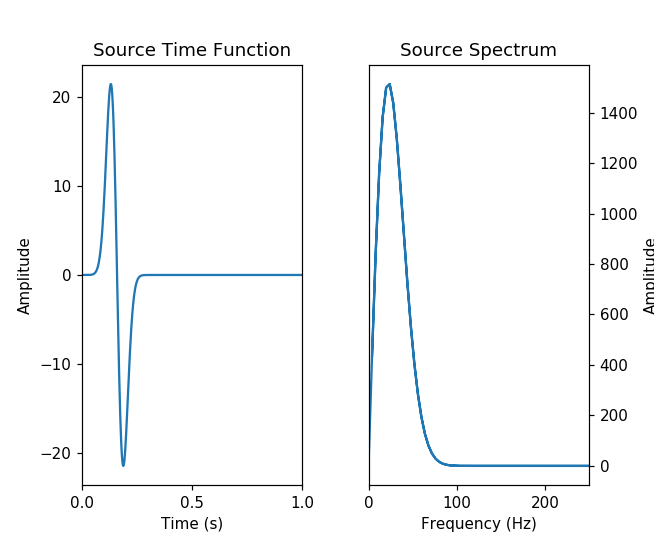

In [4]:
# Plot Source Time Function 
# -------------------------

f0   = 25. # dominant frequency of the source (Hz)
t0   = 4. / f0 # source time shift

print('Source frequency =', f0, 'Hz')

# Source time function (Gaussian)
# -------------------------------
src  = np.zeros(nt + 1)
time = np.linspace(0 * dt, nt * dt, nt)

# 1st derivative of a Gaussian
src  = -2. * (time - t0) * (f0 ** 2) * (np.exp(- (f0 ** 2) * (time - t0) ** 2))

# Plot position configuration
# ---------------------------
plt.ion()
fig1 = plt.figure(figsize=(6, 5))
gs1  = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot source time function
# -------------------------
ax1  = plt.subplot(gs1[0])
ax1.plot(time, src) # plot source time function
ax1.set_title('Source Time Function')
ax1.set_xlim(time[0], time[-1])
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

# Plot source spectrum
# --------------------
ax2  = plt.subplot(gs1[1])
spec = np.fft.fft(src) # source time function in frequency domain
freq = np.fft.fftfreq(spec.size, d = dt / 4.) # time domain to frequency domain
ax2.plot(np.abs(freq), np.abs(spec)) # plot frequency and amplitude
ax2.set_xlim(0, 250) # only display frequency from 0 to 250 Hz
ax2.set_title('Source Spectrum')
ax2.set_xlabel('Frequency (Hz)')
ax2.set_ylabel('Amplitude')

ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")

plt.show()

### Analytical Solution

In [this lecture](https://nbviewer.jupyter.org/github/daniel-koehn/Theory-of-seismic-waves-II/blob/master/01_Analytical_solutions/5_Greens_function_acoustic_1-3D.ipynb) we calculated the Green's functions for the homogenous acoustic wave equation

\begin{equation}
\frac{\partial^2}{\partial t^2} G(x,t;x_s, t_s) \ - \ vp_0^2 \Delta G(x,t;x_s, t_s) \ = \delta (x-x_s) \delta (t-t_s) \nonumber
\end{equation}

where $\Delta$ denotes the Laplace operator and the $\delta-$function is defined as

\begin{equation}
\delta(x) = \left\{
\begin{array}{ll}
	\infty &x=0 \\
	0 &x\neq 0 	
\end{array}
\right.\notag
\end{equation}

with the constraint:

\begin{equation}
\int_{-\infty}^{\infty} \delta(x)\; dx = 1.\notag
\end{equation}

When comparing numerical with analytical solutions the functions that - in the limit - lead to the $\delta-$function will become very important. An example is the boxcar function

$$
\delta_{bc}(x) = \left\{
\begin{array}{ll}
	1/dx &|x|\leq dx/2 \\
	0 &\text{elsewhere} 	
\end{array}
\right.
$$

fulfilling these properties as $dx\rightarrow0$. These functions are used to properly scale the source terms to obtain correct absolute amplitudes.

To describe analytical solutions for the acoustic wave equation we also make use of the unit step function, also known as the Heaviside function, defined as 

$$
H(x) = \left\{
\begin{array}{ll}
    0 &x<0 \\
	1 &x \geq 0 	
\end{array}
\right.
$$

The Heaviside function is the integral of the $\delta-$function (and vice-versa the $\delta$-function is defined as the derivative of the Heaviside function). In 1D case, the Greens function is proportional to a Heaviside function. 

$$
G=\frac{1}{2vp_0}H\left(t-\frac{|x|}{vp_0}\right)
$$

As the response to an arbitrary source time function can be obtained by convolution 

$$
G_{seis} = G(x,t;x_s,t_s) * s(t),
$$

this implies that the propagating waveform is the integral of the source time function. The response is shown for a source time function with a 1st derivative of a Gaussian.

<IPython.core.display.Javascript object>


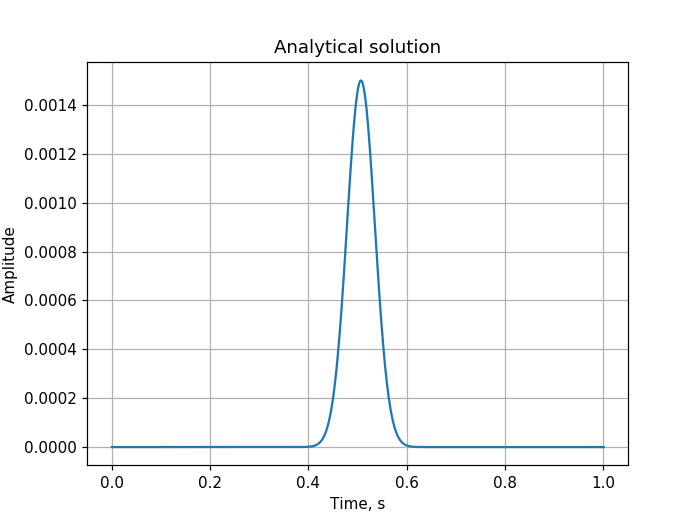

In [5]:
# Analytical solution
# -------------------
G    = time * 0.

# Initialize coordinates
# ----------------------
x    = np.arange(nx)
x    = x * dx       # coordinate in x-direction

for it in range(nt): # Calculate Green's function (Heaviside function)
    if (time[it] - np.abs(x[ir] - x[isrc]) / vp0) >= 0:
        G[it] = 1. / (2 * vp0)
Gc   = np.convolve(G, src * dt)
Gc   = Gc[0:nt]
lim  = Gc.max() # get limit value from the maximum amplitude

# Plotting convolution of Green's function with source wavelet
plt.plot(time, Gc)
plt.title("Analytical solution" )
plt.xlabel("Time, s")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

## Comparison of numerical with analytical solution

In the code below we solve the homogeneous acoustic wave equation by the 3-point difference operator and compare the numerical results with the analytical solution.

<IPython.core.display.Javascript object>


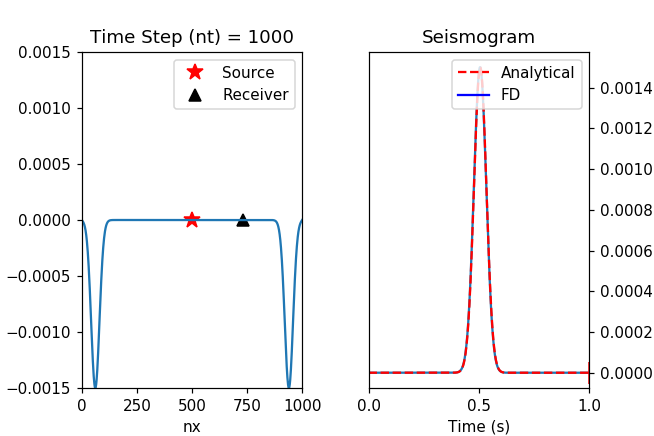

In [6]:
# Plot Snapshot & Seismogram (PLEASE RERUN THIS CODE AGAIN AFTER SIMULATION!) 
# ---------------------------------------------------------------------------

# Initialize empty pressure arrays
# --------------------------------
p    = np.zeros(nx) # p at time n (now)
pold = np.zeros(nx) # p at time n-1 (past)
pnew = np.zeros(nx) # p at time n+1 (present)
d2px = np.zeros(nx) # 2nd space derivative of p

# Initialize model (assume homogeneous model)
# -------------------------------------------
vp    = np.zeros(nx)
vp    = vp + vp0       # initialize wave velocity in model

# Initialize empty seismogram
# ---------------------------
seis = np.zeros(nt) 

# Plot position configuration
# ---------------------------
plt.ion()
fig2  = plt.figure(figsize=(6, 4))
gs2   = gridspec.GridSpec(1, 2, width_ratios=[1, 1], hspace=0.3, wspace=0.3)

# Plot 1D wave propagation
# ------------------------
# Note: comma is needed to update the variable
ax3  = plt.subplot(gs2[0])
leg1,= ax3.plot(isrc, 0, 'r*', markersize=11) # plot position of the source in snapshot
leg2,= ax3.plot(ir, 0, 'k^', markersize=8) # plot position of the receiver in snapshot
up31,= ax3.plot(p) # plot pressure update each time step
ax3.set_xlim(0, nx)
ax3.set_ylim(-lim, lim)
ax3.set_title('Time Step (nt) = 0')
ax3.set_xlabel('nx')
ax3.set_ylabel('Amplitude')
ax3.legend((leg1, leg2), ('Source', 'Receiver'), loc='upper right', fontsize=10, numpoints=1)

# Plot seismogram 
# ---------------
# Note: comma is needed to update the variable
ax4  = plt.subplot(gs2[1])
leg3,= ax4.plot(0,0,'r--',markersize=1) # plot analytical solution marker
leg4,= ax4.plot(0,0,'b-',markersize=1) # plot numerical solution marker
up41,= ax4.plot(time, seis) # update recorded seismogram each time step
up42,= ax4.plot([0], [0], 'r|', markersize=15) # update time step position
ax4.yaxis.tick_right()
ax4.yaxis.set_label_position("right")
ax4.set_xlim(time[0], time[-1])
ax4.set_title('Seismogram')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Amplitude')
ax4.legend((leg3, leg4), ('Analytical', 'FD'), loc='upper right', fontsize=10, numpoints=1)

plt.plot(time,Gc,'r--') # plot analytical solution
plt.show()

In [7]:
# 1D Wave Propagation (Finite Difference Solution) 
# ------------------------------------------------

# Calculate Partial Derivatives
# -----------------------------
for it in range(nt):
    
    # FD approximation of spatial derivative by 3 point operator
    for i in range(1, nx - 1):
        d2px[i] = (p[i + 1] - 2 * p[i] + p[i - 1]) / dx ** 2

    # Time Extrapolation
    # ------------------
    pnew = 2 * p - pold + vp ** 2 * dt ** 2 * d2px

    # Add Source Term at isrc
    # -----------------------
    # Absolute pressure w.r.t analytical solution
    pnew[isrc] = pnew[isrc] + src[it] / dx * dt ** 2
                
    # Remap Time Levels
    # -----------------
    pold, p = p, pnew
    
    # Output Seismogram
    # -----------------
    seis[it] = p[ir]
    
    # Update Data for Wave Propagation Plot
    # -------------------------------------
    idisp = 2 # display frequency
    if (it % idisp) == 0:
        ax3.set_title('Time Step (nt) = %d' % it)
        up31.set_ydata(p)
        up41.set_ydata(seis)
        up42.set_data(time[it], seis[it])
        plt.gcf().canvas.draw()

## What we learned:

* implementation of the 1D acoustic wave equation 
* understanding the input parameters for the simulation and the plots that are generated
* modifying source and receiver locations and observing the effects on the seismograms
* allowing you to explore the finite-difference method